# Forecasting using FFNN

- One-step recursive forecasting

In [1]:
import pandas as pd
import numpy as np
import os
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing methods
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# accuracy measures and data spliting
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# deep learning libraries
from keras.models import Input, Model
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
from keras import callbacks
from keras import initializers
from keras import regularizers

import warnings

Using TensorFlow backend.


In [2]:
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 15, 7

## 1. Data import

In [4]:
DATADIR = '../data/power-consumption/'
MODELDIR = '../checkpoints/power/ffnn/model/'

In [5]:
data = pd.read_csv(os.path.join(DATADIR, 'processed_data.csv'))

In [6]:
data.head()

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4,Month,Weekday,WeekOfYear,Median_active_power,Lagged_active_power,median_residual
0,2006-12-16,1209.176,34.922,236.243763,5180.8,0.0,546.0,4926.0,14680.933333,12,5,50,2437.799,2437.799,-1228.623
1,2006-12-17,3390.460,226.006,240.087028,14398.6,2033.0,4187.0,13341.0,36946.666667,12,6,50,2437.894,1209.176,952.566
2,2006-12-18,2203.826,161.792,241.231694,9247.2,1063.0,2621.0,14018.0,19028.433333,12,0,51,1833.155,3390.460,370.671
3,2006-12-19,1666.194,150.942,241.999313,7094.0,839.0,7602.0,6197.0,13131.900000,12,1,51,1971.630,2203.826,-305.436
4,2006-12-20,2225.748,160.998,242.308063,9313.0,0.0,2648.0,14063.0,20384.800000,12,2,51,2031.487,1666.194,194.261


## 2. Train test split

In [7]:
y = data[['Global_active_power']].copy()
X = data.drop(columns=['date', 'Global_active_power', 'Median_active_power', 'Lagged_active_power', 'median_residual'], axis=1)

# last 40 weeks data for testing
test_size = np.int16(7*1)
train_size = X.shape[0] - test_size

In [8]:
# scaling weekly sales, dependent variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values)

# scaling numerical column from features
x_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X.values)

In [9]:
X_train, X_test = X_scaled[:train_size-1, :], X_scaled[train_size:, :]
y_train, y_test = y_scaled[:train_size-1, :], y_scaled[train_size:, :]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1434, 10), (7, 10), (1434, 1), (7, 1))

## 4. Model Builing

In [10]:
def model_construction():
    
    features = X_train.shape[1]
    # xavier initializer 
    xavier = initializers.glorot_normal()

    model = Sequential()
    model.add(Dense(8, input_dim = features, kernel_initializer=xavier, 
                    activation='relu'))
    model.add(Dense(16, input_dim = features, kernel_initializer=xavier, 
                    activation='relu'))
    model.add(Dense(16, input_dim = features, kernel_initializer=xavier, 
                    activation='relu'))
    model.add(Dense(8, input_dim = features, kernel_initializer=xavier, 
                    activation='relu'))
    model.add(Dense(1, kernel_initializer=xavier))
 
    model.summary()
    
    return model

In [11]:
def traning(model, X_train, y_train, MODELDIR):
    
    start = time.time()
    
    model.compile(loss=losses.mean_squared_error, optimizer=optimizers.Adam(), metrics=[metrics.mean_absolute_error])
    
    callbacks_list = [callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)]
    
    history = model.fit(X_train, y_train, 
                        epochs=50, 
                        batch_size=32, 
                        verbose=0,
                        shuffle=False,
                        callbacks=callbacks_list
                       )

    y_train_pred = model.predict(X_train)

    # recursive model fitting
    onestep_pred = []
    for i in range(X_test.shape[0]):
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, shuffle=False)

        pred = model.predict(X_test[i, :].reshape(1, -1))
        onestep_pred.append(pred)

        tempX = np.vstack((X_train, X_test[i, :]))    
        X_train = tempX.copy()

        arr_pred = np.array([pred]).reshape(-1, 1)
        tempY = np.vstack((y_train, arr_pred))
        y_train = tempY.copy()
    
    y_test_pred = np.array(onestep_pred).reshape(-1, 1)
    
    # directory for saving model 
    if os.path.exists(MODELDIR):
        pass
    else:
        os.makedirs(MODELDIR)
        
    model.save(os.path.join(MODELDIR, 'fc-v2.h5'))
    model.save_weights(os.path.join(MODELDIR, 'fc-v2-weights.h5'))
    
    end = time.time()
    time_taken = np.round((end-start), 3)
    print(f'Time taken to complete the process: {time_taken} seconds')

    return history, y_train_pred, y_test_pred

In [12]:
model = model_construction()
history, y_train_pred, y_test_pred = traning(model, X_train, y_train, MODELDIR)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 649
Trainable params: 649
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 20.237 seconds


## 5. Model evaluation

In [13]:
def model_evaluation(y_train, y_test, y_train_pred, y_test_pred):
    
    y_train_inv = y_scaler.inverse_transform(y_train)
    y_test_inv = y_scaler.inverse_transform(y_test)
    
    y_train_pred_inv = y_scaler.inverse_transform(y_train_pred)
    y_test_pred_inv = y_scaler.inverse_transform(y_test_pred)
    
    # MAE and NRMSE calculation
    train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
    train_mae = np.round(mean_absolute_error(y_train_inv, y_train_pred_inv), 3)
    train_nrmse = np.round(train_rmse/np.std(y_train_inv), 3)

    test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
    test_mae = np.round(mean_absolute_error(y_test_inv, y_test_pred_inv), 3)
    test_nrmse = np.round(test_rmse/np.std(y_test_inv), 3)

    print(f'Training MAE: {train_mae}')
    print(f'Trainig NRMSE: {train_nrmse}')

    print(f'Test MAE: {test_mae}')
    print(f'Test NRMSE: {test_nrmse}')
    
    return y_train_inv, y_train_pred_inv, y_test_inv, y_test_pred_inv

In [14]:
y_train_inv, y_train_pred_inv, y_test_inv, y_test_pred_inv = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

Training MAE: 30.76
Trainig NRMSE: 0.069
Test MAE: 10.397
Test NRMSE: 0.048


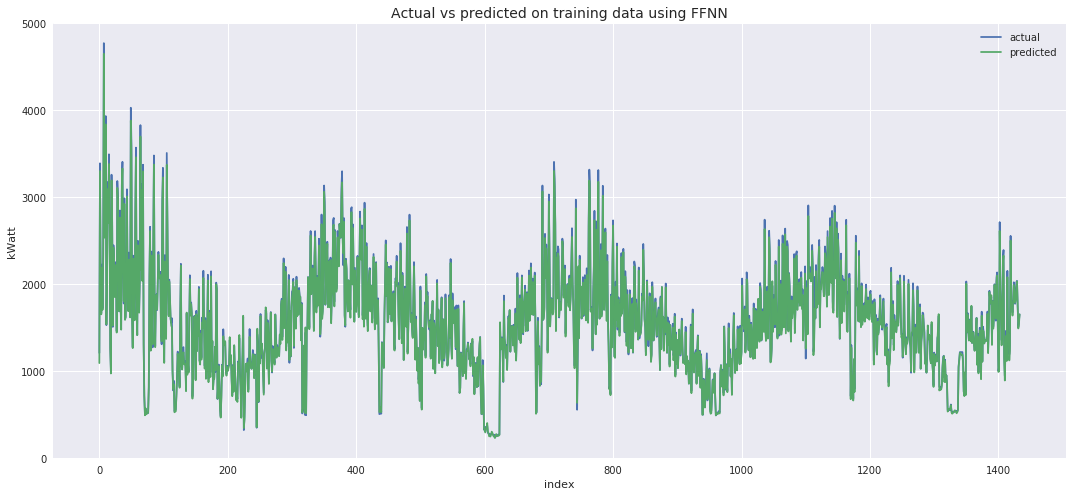

In [15]:
plt.plot(y_train_inv, label='actual')
plt.plot(y_train_pred_inv, label='predicted')
plt.ylabel('kWatt')
plt.xlabel('index')
plt.title('Actual vs predicted on training data using FFNN', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

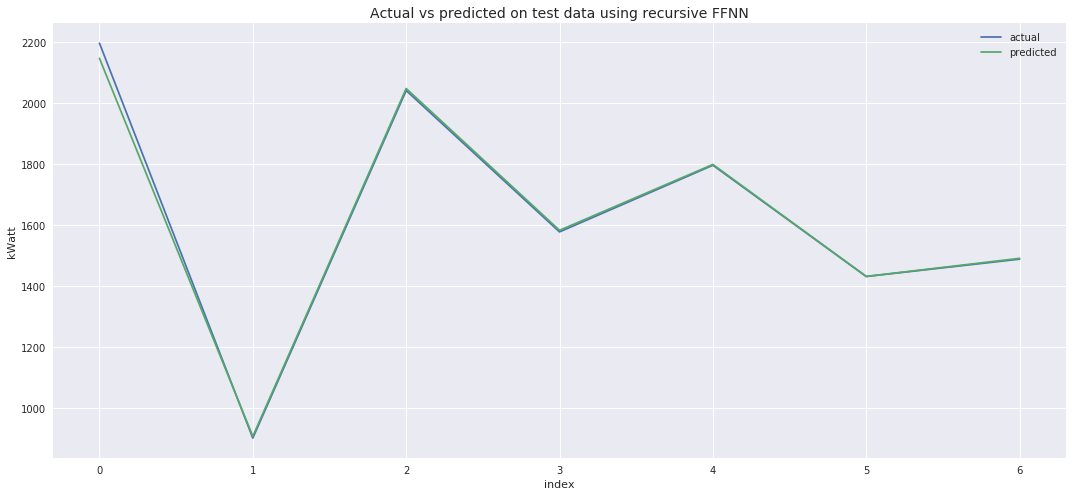

In [16]:
plt.plot(y_test_inv, label='actual')
plt.plot(y_test_pred_inv, label='predicted')
plt.ylabel('kWatt')
plt.xlabel('index')
plt.title('Actual vs predicted on test data using recursive FFNN', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()